# <span style="color:purple"> Radiative Effect & Forcing Calculations Following Ghan Methodology :


<span style="color:#fc8d62"><b>direct aerosol forcing</b></span> = (FSNTOA_dataset1 - FSNTOA_d2_dataset1) - (FSNTOA_dataset2 - FSNTOA_d2_dataset2)

<span style="color:#8da0cb"><b>cloud_aerosol_forcing</b></span> = (FSNTOA_d2_dataset1 - FSNTOAC_d2_dataset1) - (FSNTOA_d2_dataset2 - FSNTOAC_d2_dataset2)

<span style="color:#66c2a5"><b>surface_albedo_forcing</b></span> = FSNTOAC_d2_dataset1 - FSNTOAC_d2_dataset2

<span style="color:#e78ac3"><b>total_aerosol_forcing</b></span> = direct_aerosol_forcing + cloud_aerosol_forcing + surface_albedo_forcing

### <span style="color:purple"> Imports

In [2]:
# Standard library
import sys
import calendar

# Third-party libraries
import xarray as xr
import matplotlib.pyplot as plt

# Custom utilities
import utils
from utils.load_variable import load_variables_for_all_years

### <span style="color:purple"> Loading RRTMG Variables

In [3]:
Base = load_variables_for_all_years('h0', 'FSNTOA')
Clean = load_variables_for_all_years('h0', 'FSNTOA_d2')
Clear = load_variables_for_all_years('h0', 'FSNTOAC')
Clean_Clear = load_variables_for_all_years('h0', 'FSNTOAC_d2')

### <span style="color:purple"> Calculating Radiative Effects (within year) and Forcings (across years)

In [54]:
def direct_radiative_effect(year_1):
    return Base[year_1] - Clean[year_1]

def cloud_radiative_effect(year_1):
    return Clean[year_1] - Clean_Clear[year_1]


forcing_direct = direct_radiative_effect('2006') - direct_radiative_effect('1970')

forcing_cloud = cloud_radiative_effect('2006') - cloud_radiative_effect('1970')

forcing_albedo = Clean_Clear['2006'] - Clean_Clear['1970']

### <span style="color:purple"> Deriving Monthly Radiative Forcing Climatologies

In [68]:
NPAC_mask = xr.open_dataarray('/glade/u/home/jzweifel/jupyter_workspaces/Masters_paper_analysis/Figure_1/NPO_lower_bound_20_deg.nc')
AREA = xr.open_dataarray('/glade/derecho/scratch/jzweifel/Regional_Masks_And_Area/area_files/AREA.nc')

def make_climatology(dataset, mask, area):
    weights = mask*area
    climatology = dataset.groupby("time.month").mean(dim="time").weighted(weights).mean(dim=["lat","lon"])
    return climatology

direct_forcing_climo = make_climatology(forcing_direct, NPAC_mask, AREA)
cloud_forcing_climo = make_climatology(forcing_cloud, NPAC_mask, AREA)
albedo_forcing_climo = make_climatology(forcing_albedo , NPAC_mask, AREA)
total_forcing_climo = make_climatology((forcing_direct+forcing_cloud+forcing_albedo), NPAC_mask, AREA)

### <span style="color:purple"> Plotting Monthly Radiative Forcing Climatologies

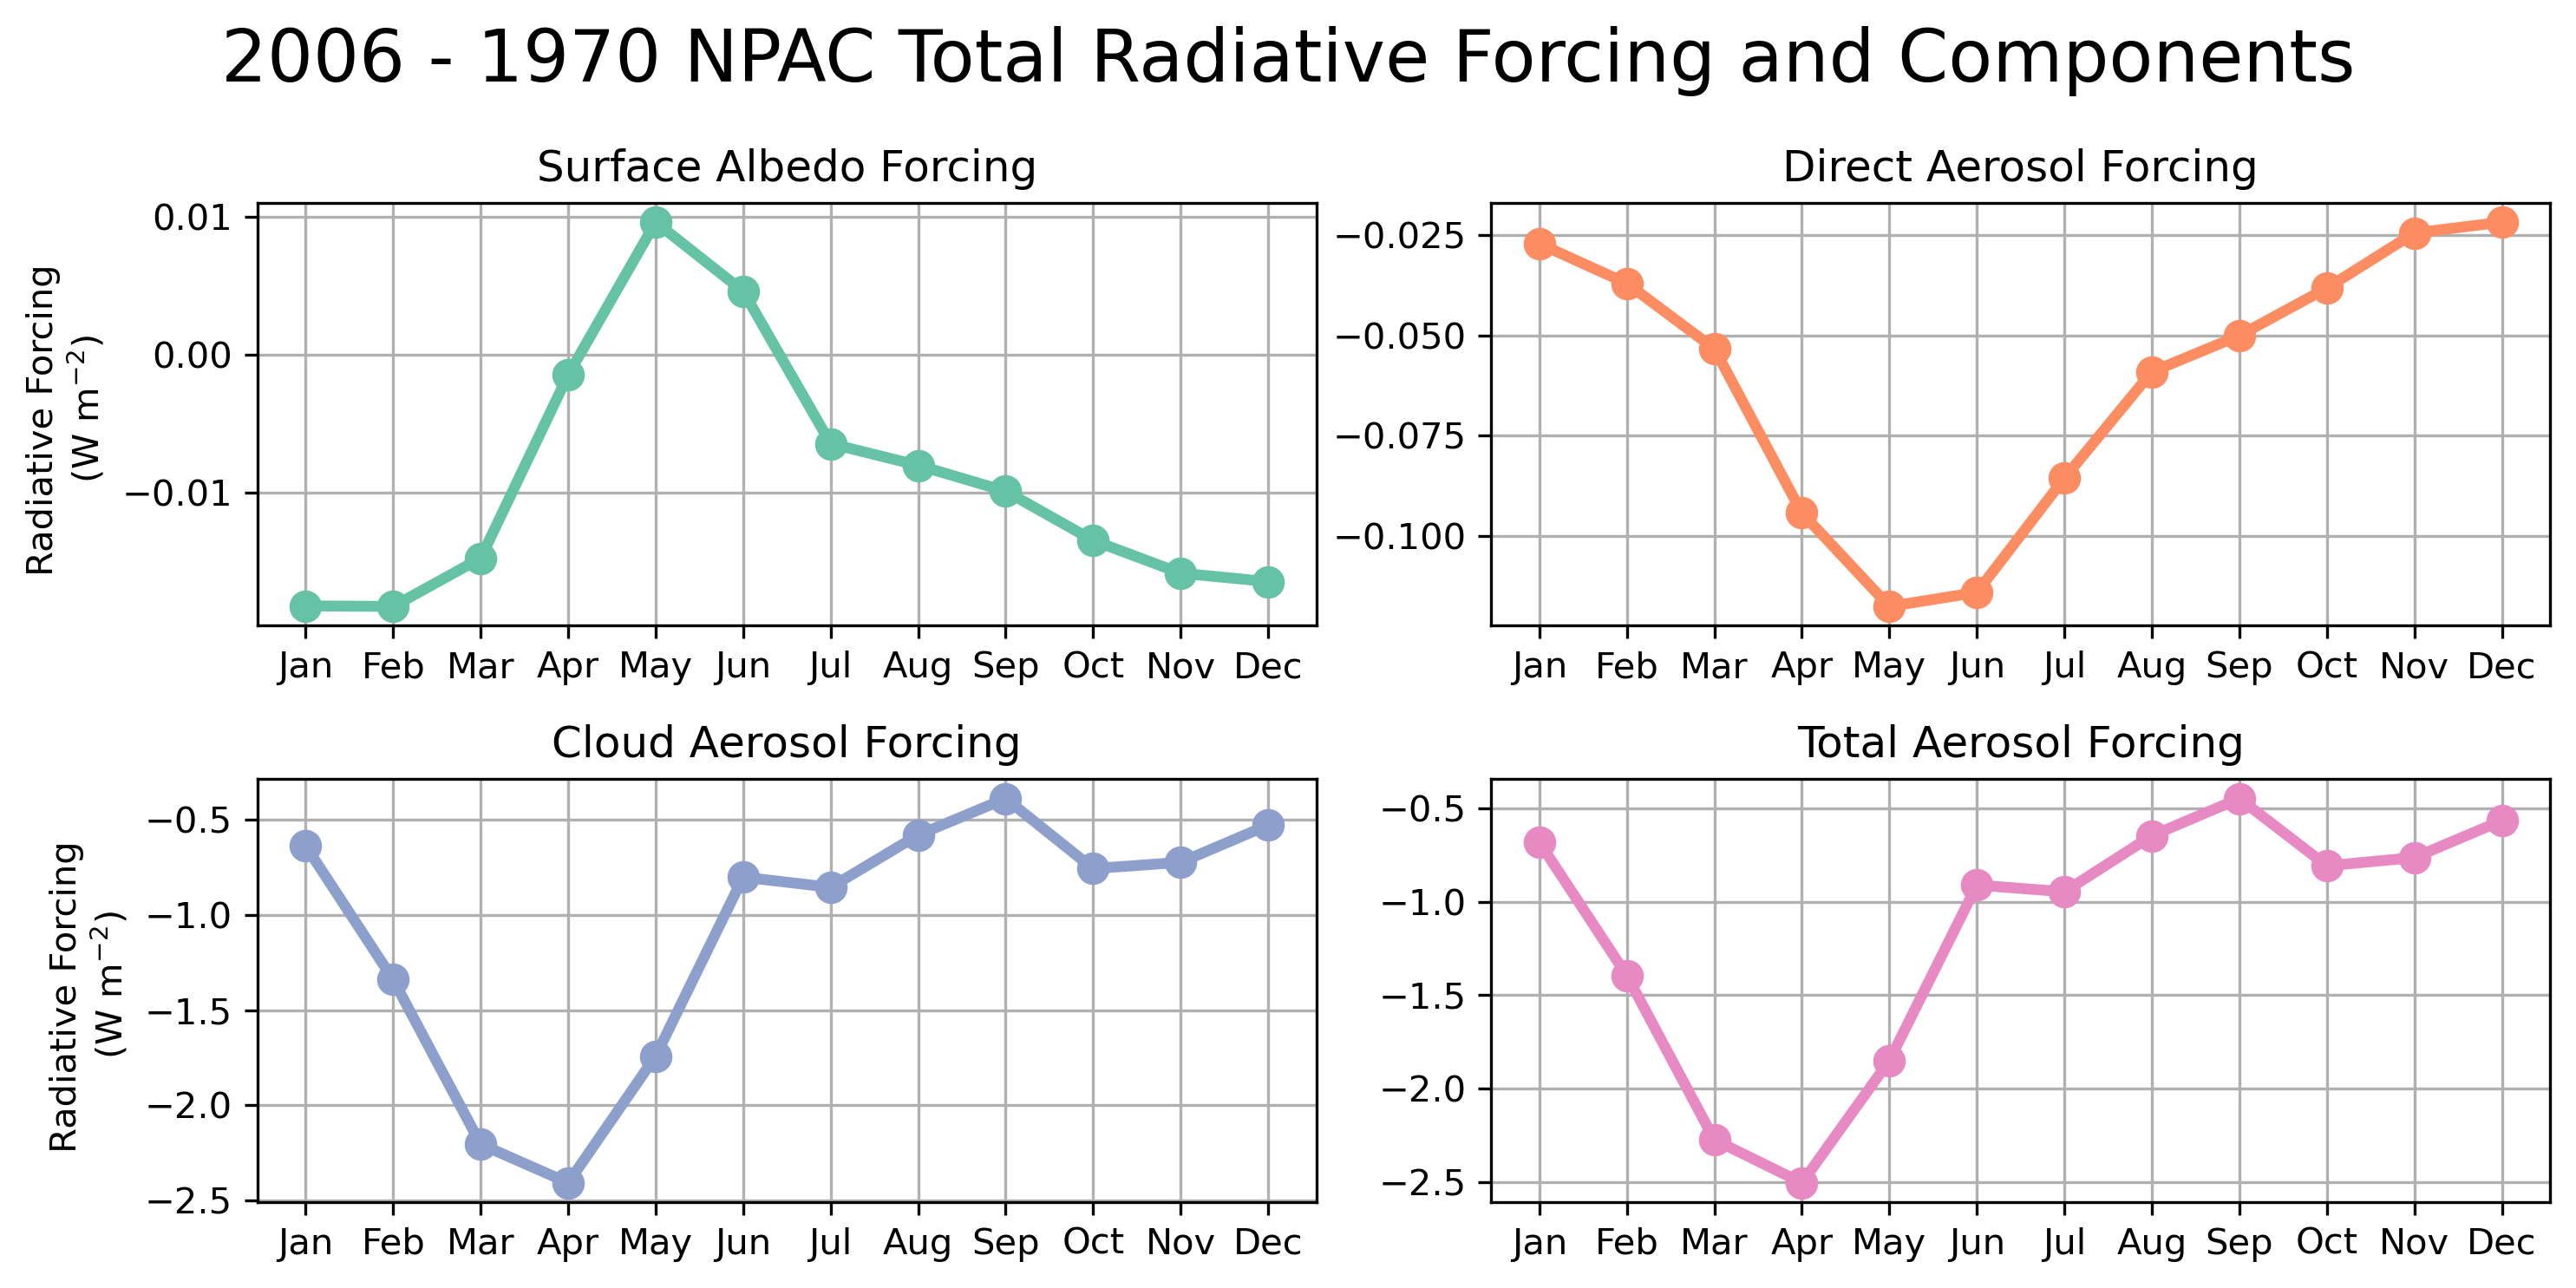

In [69]:
import calendar
import seaborn as sns

months = calendar.month_abbr[1:]
color_palette = sns.color_palette("Set2")

fig, axs = plt.subplots(2,2, figsize=(10,5), dpi=300)

axs[0,0].plot(months, albedo_forcing_climo.roll(month=-1), marker='o', markersize=8, color=color_palette[0], lw=3)
axs[0,0].set_ylabel('Radiative Forcing \n (W m$^{-2}$)')
axs[0,0].set_title('Surface Albedo Forcing')
axs[0,0].grid()
axs[0,1].plot(months, direct_forcing_climo.roll(month=-1), marker='o', markersize=8, color=color_palette[1], lw=3)
axs[0,1].set_title('Direct Aerosol Forcing')
axs[0,1].grid()
axs[1,0].plot(months, cloud_forcing_climo.roll(month=-1), marker='o', markersize=8, color=color_palette[2], lw=3)
axs[1,0].set_ylabel('Radiative Forcing \n (W m$^{-2}$)')
axs[1,0].set_title('Cloud Aerosol Forcing')
axs[1,0].grid()
axs[1,1].plot(months, total_forcing_climo.roll(month=-1), marker='o', markersize=8, color=color_palette[3], lw=3)
axs[1,1].set_title('Total Aerosol Forcing')
axs[1,1].grid()

fig.suptitle('2006 - 1970 NPAC Total Radiative Forcing and Components', fontsize=20)
plt.tight_layout()

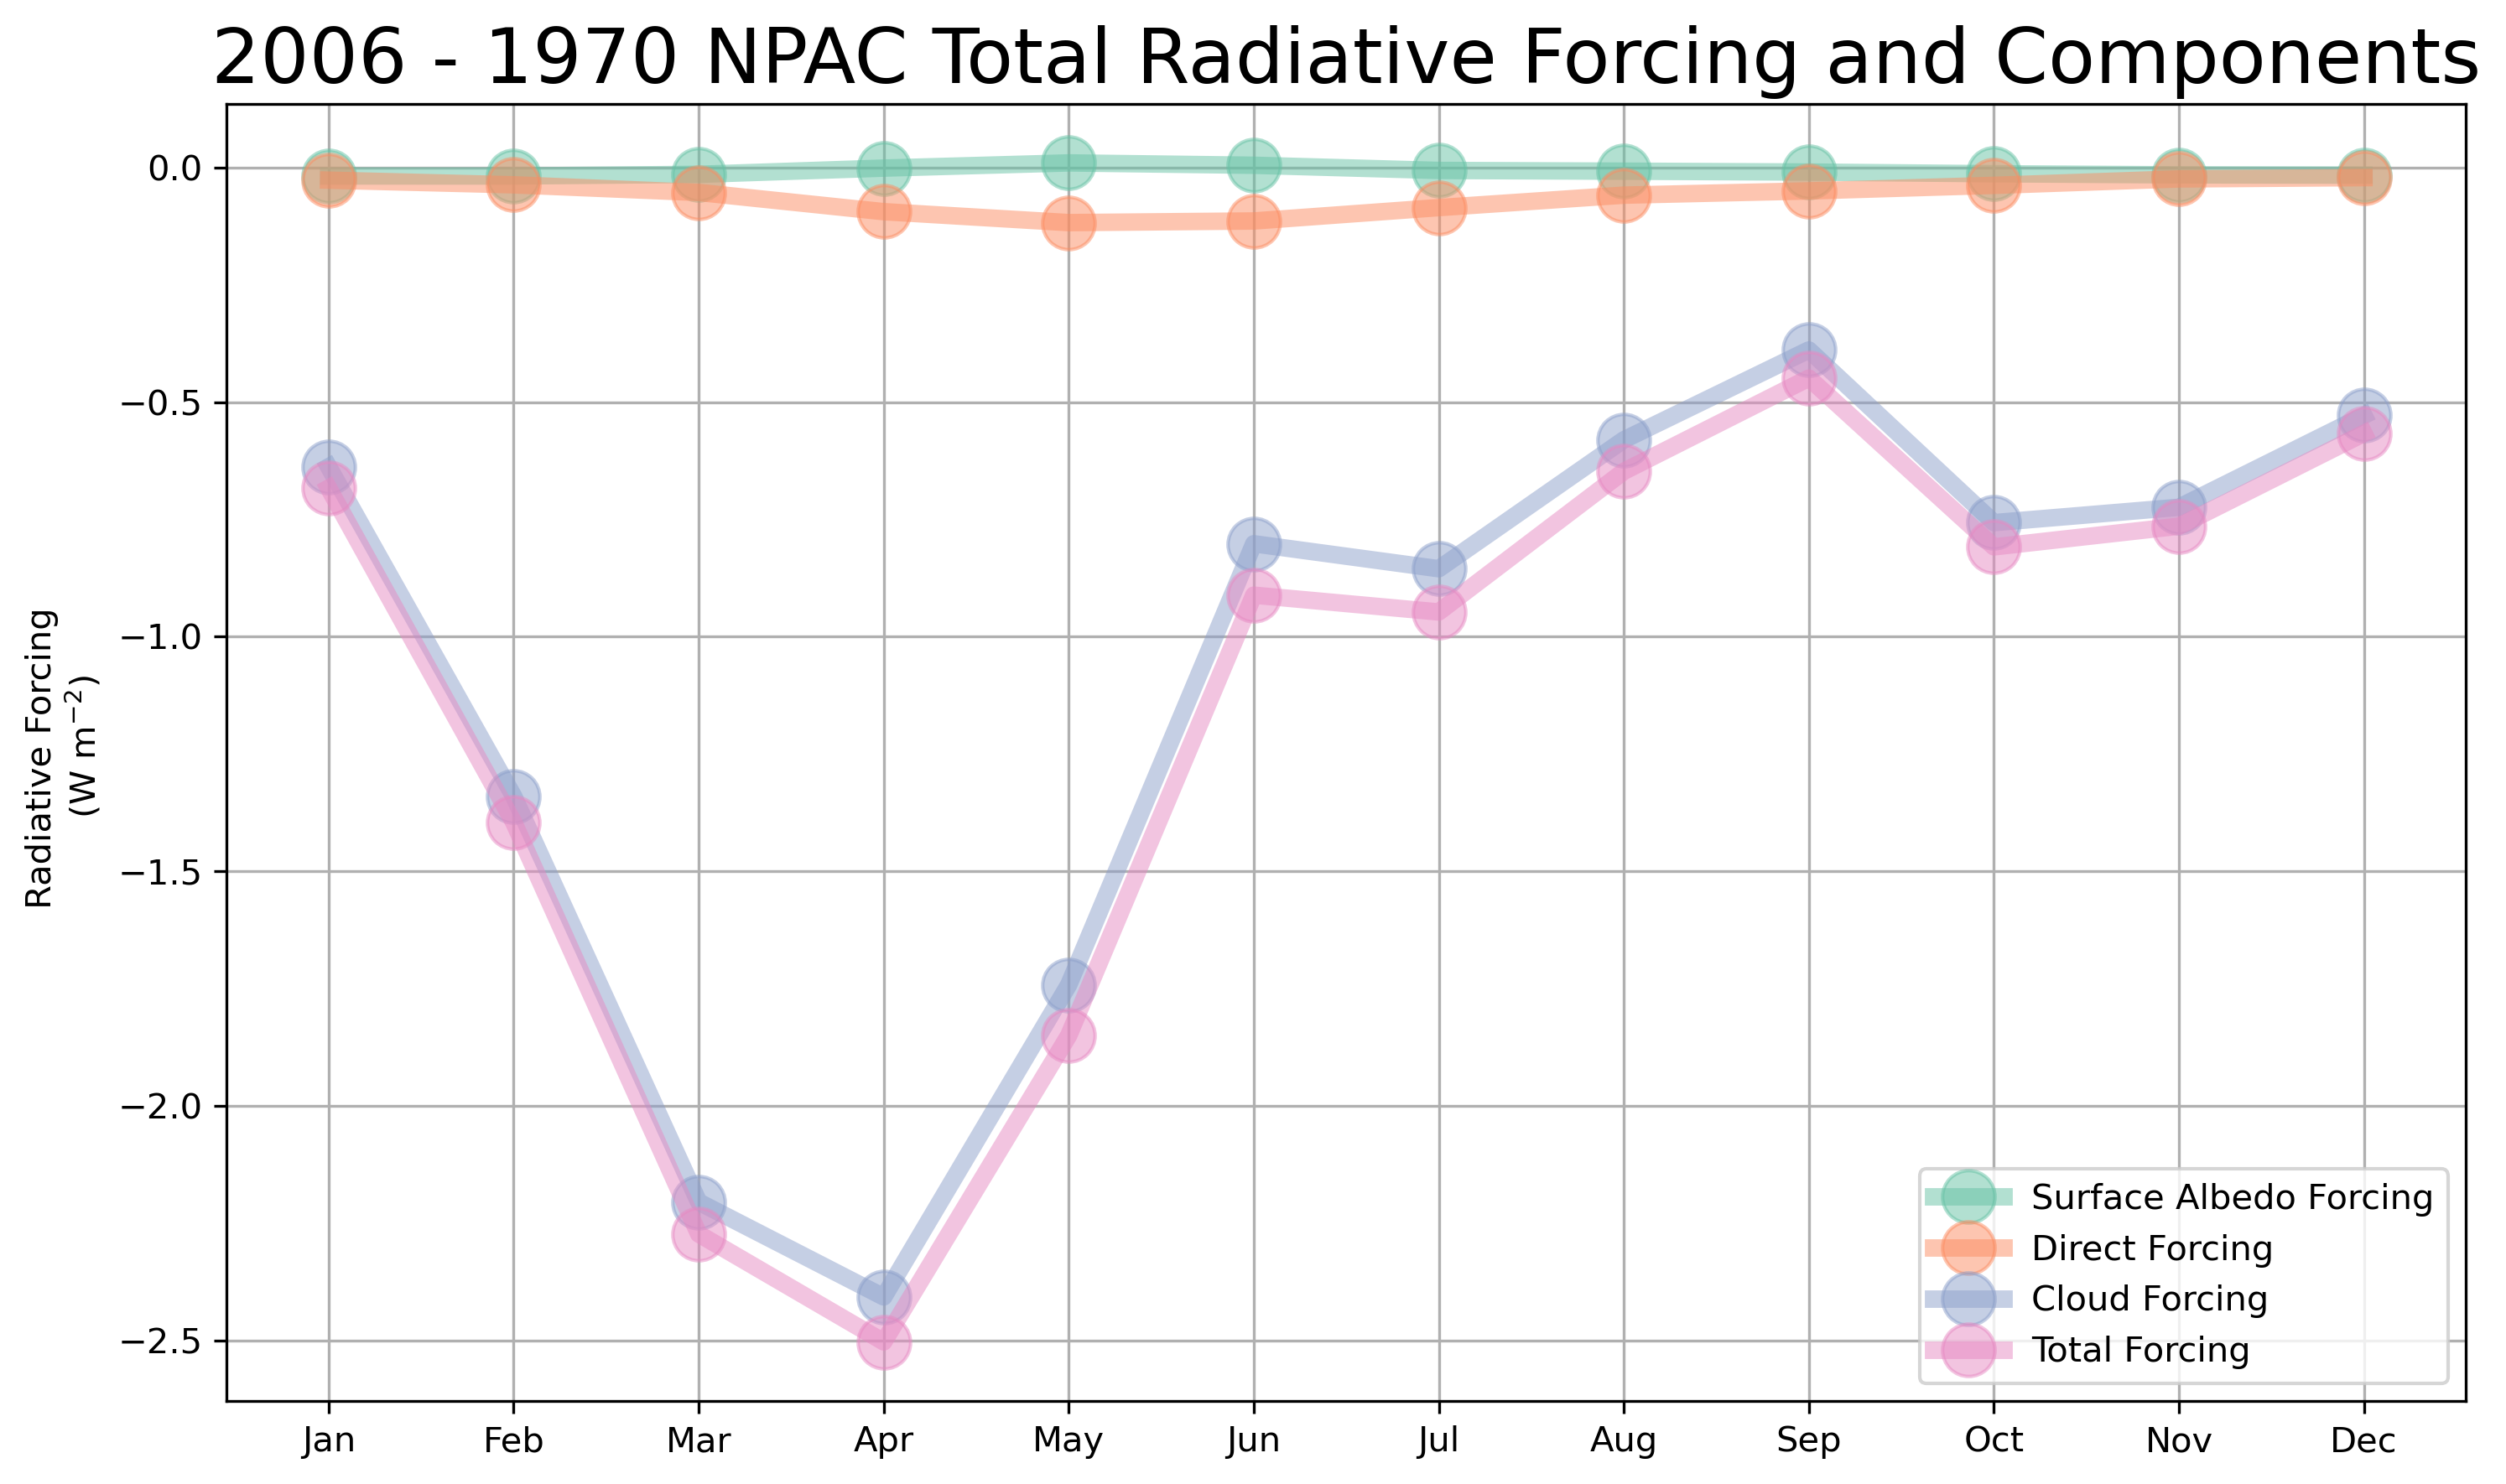

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6), dpi=300)  # Optional: adjust size to make it look nice at high DPI

plt.plot(months, albedo_forcing_climo.roll(month=-1), marker='o', markersize=15, lw=5, alpha=0.5, label='Surface Albedo Forcing', color=color_palette[0])
plt.plot(months, direct_forcing_climo.roll(month=-1), marker='o', markersize=15, lw=5, alpha=0.5, label='Direct Forcing', color=color_palette[1])
plt.plot(months, cloud_forcing_climo.roll(month=-1), marker='o', markersize=15, lw=5, alpha=0.5, label='Cloud Forcing', color=color_palette[2])
plt.plot(months, total_forcing_climo.roll(month=-1), marker='o', markersize=15, lw=5, alpha=0.5, label='Total Forcing', color=color_palette[3])

plt.grid()
plt.ylabel('Radiative Forcing \n (W m$^{-2}$)')
plt.title('2006 - 1970 NPAC Total Radiative Forcing and Components', fontsize=22)
plt.legend()

plt.tight_layout()  # Makes sure labels and titles don't get cut off
plt.show()  # Show it on screen as usual

In [77]:
import numpy as np

# all-sky Δ between 2006 and 1970 (NPAC-weighted monthly climatology)
delta_allsky = make_climatology(Base['2006'], NPAC_mask, AREA) - \
               make_climatology(Base['1970'], NPAC_mask, AREA)

recon = total_forcing_climo  # your sum: direct + cloud + albedo
print("allclose (closure)?", np.allclose(recon, delta_allsky, rtol=1e-5, atol=1e-12))

diff = recon - delta_allsky
print("max |closure error|:", float(np.max(np.abs(diff))))

allclose (closure)? True
max |closure error|: 1.532972974671587e-07


In [80]:
def climo(x): 
    return make_climatology(x, NPAC_mask, AREA)

cloud_check = (climo(Clean['2006']) - climo(Clean_Clear['2006'])) - \
              (climo(Clean['1970']) - climo(Clean_Clear['1970']))

print("cloud_check ~ cloud_forcing_climo?",
      np.allclose(cloud_check, cloud_forcing_climo, rtol=1e-5, atol=1e-12))
print("max |diff|:", float(np.max(np.abs(cloud_check - cloud_forcing_climo))))

cloud_check ~ cloud_forcing_climo? True
max |diff|: 4.650363994995743e-07


In [78]:
CRE_2006      = make_climatology(Base['2006'],      NPAC_mask, AREA) - make_climatology(Clear['2006'],      NPAC_mask, AREA)
CRE_noSO4_2006= make_climatology(Clean['2006'],     NPAC_mask, AREA) - make_climatology(Clean_Clear['2006'],NPAC_mask, AREA)
CRE_1970      = make_climatology(Base['1970'],      NPAC_mask, AREA) - make_climatology(Clear['1970'],      NPAC_mask, AREA)
CRE_noSO4_1970= make_climatology(Clean['1970'],     NPAC_mask, AREA) - make_climatology(Clean_Clear['1970'],NPAC_mask, AREA)

cloud_alt = (CRE_2006 - CRE_noSO4_2006) - (CRE_1970 - CRE_noSO4_1970)

print("cloud_alt ~ cloud_forcing_climo?",
      np.allclose(cloud_alt, cloud_forcing_climo, rtol=1e-8, atol=1e-12))

diff = cloud_alt - cloud_forcing_climo
print("max |closure error|:", float(np.max(np.abs(diff))))

cloud_alt ~ cloud_forcing_climo? False
max |closure error|: 2.5947882475383865


In [73]:
# recompute components explicitly from datasets
direct_check = (make_climatology(Base['2006'], NPAC_mask, AREA) - 
                make_climatology(Clean['2006'], NPAC_mask, AREA)) - \
               (make_climatology(Base['1970'], NPAC_mask, AREA) - 
                make_climatology(Clean['1970'], NPAC_mask, AREA))

cloud_check = (make_climatology(Clean['2006'], NPAC_mask, AREA) - 
               make_climatology(Clean_Clear['2006'], NPAC_mask, AREA)) - \
              (make_climatology(Clean['1970'], NPAC_mask, AREA) - 
               make_climatology(Clean_Clear['1970'], NPAC_mask, AREA))

albedo_check = make_climatology(Clean_Clear['2006'], NPAC_mask, AREA) - \
               make_climatology(Clean_Clear['1970'], NPAC_mask, AREA)

recon_check = direct_check + cloud_check + albedo_check

print("closure?", np.allclose(delta_allsky, recon_check, rtol=1e-8, atol=1e-12))
print("max closure error:", float(np.max(np.abs(recon_check - delta_allsky))))

closure? True
max closure error: 0.0
